In [19]:
import IPython
from IPython.display import Image
import random
import librosa
import string
import ffmpy
import os
import matplotlib.pyplot as plt
%matplotlib inline
from liveid import *
import datetime

ap = parameters()

def load_file(file_name, scale=1):
    x, sr = librosa.load(file_name)
    ap['sample_rate'] = sr*scale
    cqt, fp = fingerprint(x, ap)
    return x, sr, cqt, fp

def show_figure(fig_path, width):
    IPython.display.display(Image(fig_path, width = width))

def load_and_display(audio_path, title, aspect):
    audio_signal, sr, audio_cqt, audio_fp = load_file(audio_path)
    display_spectrogram_and_audio(audio_cqt, audio_fp, audio_signal, sr, title, aspect)
    
def display_spectrogram(stft, title, cmap, aspect):
    notes = ['C3', 'G3', 'C4', 'G4', 'C5', 'G5', 'C6', 'G6']
    numbers = np.array([0, 7, 13, 19, 25, 31, 37, 43])*2
    plt.figure(figsize=(15, 8))
    plt.imshow(stft, origin='lower', cmap=cmap, aspect = aspect)
    plt.title(title)
    plt.xticks(range(stft.shape[1])[::50], [str(datetime.timedelta(seconds=np.round(i / 10)))[3:] 
                                   for i in range(stft.shape[1])][::50], ha='left', rotation='vertical')
    plt.ylim([0, stft.shape[0]])
    plt.yticks(numbers, notes, va='bottom')
    plt.ylabel('Pitch')
    plt.xlabel('Time')
    plt.show()
    
def display_spectrogram_and_audio(cqt, fp, audio_signal, sr, title, aspect):
    display_spectrogram(cqt, title, 'PuRd', aspect)
    display_spectrogram(fp, title, 'Greys', aspect)
    audio(audio_signal, sr)

def audio(d, sr):
    tmp_file = 'tmp.mp3'
    file_path = 'tmp.wav'
    librosa.output.write_wav('tmp.wav', d, sr)
    ff = ffmpy.FFmpeg(
        inputs={file_path: None},
        outputs={tmp_file: None})
    ff.run()
    IPython.display.display(IPython.display.Audio(tmp_file))
    os.remove('tmp.mp3')
    os.remove('tmp.wav')
    
from IPython.core.display import HTML
HTML("""
<style>
audio {
    width: 100%;
}
.output_png {
    text-align: center;
}
</style>
""")

In [20]:
from scipy.ndimage.filters import gaussian_filter

fingerprint_parameters = {
    'window_seconds': 20,
    'hop_factor': .2
}

def fingerprint_fft(raw_fingerprint, audio_parameters, fingerprint_parameters):
    window_seconds = fingerprint_parameters['window_seconds']
    hop_factor = fingerprint_parameters['hop_factor']
    sample_rate = audio_parameters['sample_rate']
    window_length = window_seconds*audio_parameters['time_resolution']
    ffts = []
    start = 0
    while start <= raw_fingerprint.shape[1] - window_length:
        fft = np.fft.fft2(raw_fingerprint[:, start:start+window_length])
        fft = gaussian_filter(np.abs(np.fft.fftshift(fft)), sigma=.375)
        #fft = np.abs(np.fft.fftshift(fft))
        ffts.append(fft)
        start += int(window_length * hop_factor)   
    return ffts

In [33]:
#song_fp = load_file("../../coversong_identification/datasets/Elvis Presley - Can't Help Falling In Love/Can't Help Falling In Love-5V430M59Yn8.mp3")[-1]
#cover_fp = load_file("../../coversong_identification/datasets/Elvis Presley - Can't Help Falling In Love/Can't Help Falling in Love - Elvis Presley (Ukulele Cover by Stormy Amorette)-qlwnRhlh7ts.mp3")[-1]

song_fp = load_file("../data/test_data/Luis Fonsi - Despacito ft. Daddy Yankee.mp3")[-1]
cover_fp = load_file("../data/test_data/Despacito cover - Luciana Zogbi.mp3")[-1]

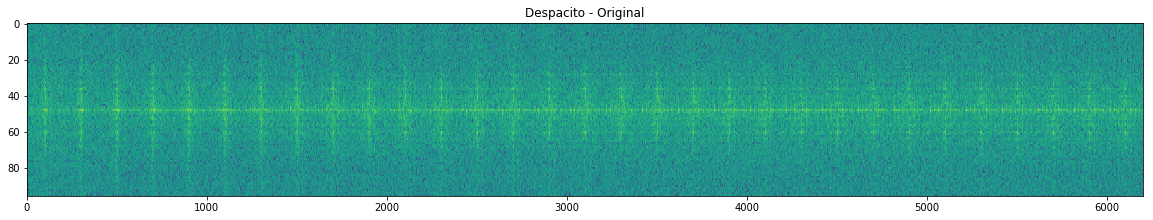

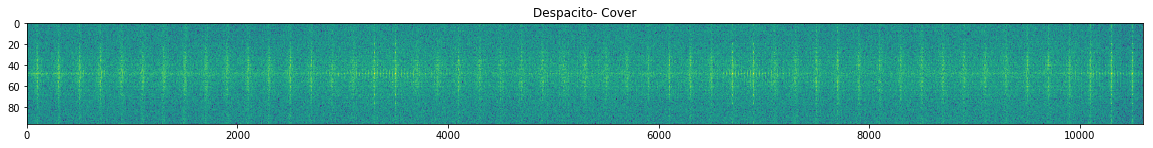

In [35]:
song_ffts = fingerprint_fft(song_fp, ap, fingerprint_parameters)
cover_ffts = fingerprint_fft(cover_fp, ap, fingerprint_parameters)
plt.figure(figsize=(20, 4))
plt.imshow(np.log(np.hstack(song_ffts))**.5, aspect = 10)
plt.title("Despacito - Original")
plt.show()

# plt.figure(figsize=(20, 4))
# plt.imshow(np.log(np.hstack(cover_ffts))**.5, aspect = 10)
# plt.title("Can't Help Falling In Love With You - Pitch shifted")
# plt.show()

plt.figure(figsize=(20, 4))
plt.imshow(np.log(np.hstack(cover_ffts))**.5, aspect = 10)
plt.title("Despacito- Cover")
plt.show()

(19200, 53)
(19200, 31)


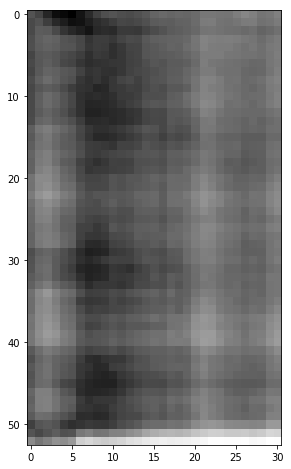

In [36]:
from scipy.spatial.distance import *

def fft_sequence_similarity(ffts_query, ffts_reference):
    ffts_query = np.vstack([f.flatten() for f in ffts_query]).T
    print ffts_query.shape
    ffts_reference = np.vstack([f.flatten() for f in ffts_reference]).T
    print ffts_reference.shape
    similarities = cdist(ffts_query.T, ffts_reference.T, 'euclidean')
    energy = np.mean(similarities)
    similarities = similarities / np.max(similarities)
    return 1 - similarities, energy

sim, energy = fft_sequence_similarity(cover_ffts, song_ffts)
plt.figure(figsize=(8, 8))
plt.imshow(sim, cmap='Greys', interpolation='none')
plt.show()

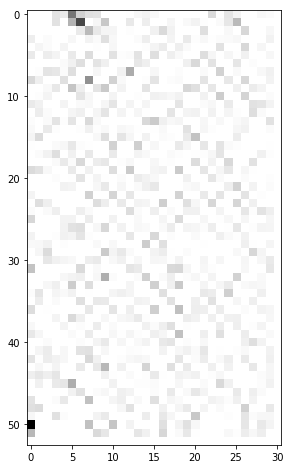

In [37]:
from scipy.ndimage import convolve

def filter_similarity_matrix(S):
    filtered = np.copy(S)
    filtered = filtered  / np.max(filtered)
    kernel = np.array([[1, -1], [-1, 1]])
    filtered = convolve(filtered, kernel)
    filtered[filtered < 0] = 0
    return filtered

filtered = filter_similarity_matrix(sim)
plt.figure(figsize=(8, 8))
plt.imshow(filtered, cmap='Greys', interpolation='none')
plt.show()

In [39]:
from fft_sequence_fingerprint import *

scales = [.9, .95, 1, 1.05]
resampled_references = []
song, sr = librosa.load("../data/test_data/Luis Fonsi - Despacito ft. Daddy Yankee.mp3")

for s in scales:
    ap['sample_rate'] = s*sr
    song_fp = fingerprint(song, ap)[1]
    song_ffts = fingerprint_fft(song_fp, ap, fingerprint_parameters)
    resampled_references.append(song_ffts)
    
cover, sr = librosa.load("../data/test_data/Despacito cover - Luciana Zogbi.mp3")
ap['sample_rate'] = sr
cover_fp = fingerprint(cover, ap)[1]
cover_ffts = fingerprint_fft(cover_fp, ap, fingerprint_parameters)

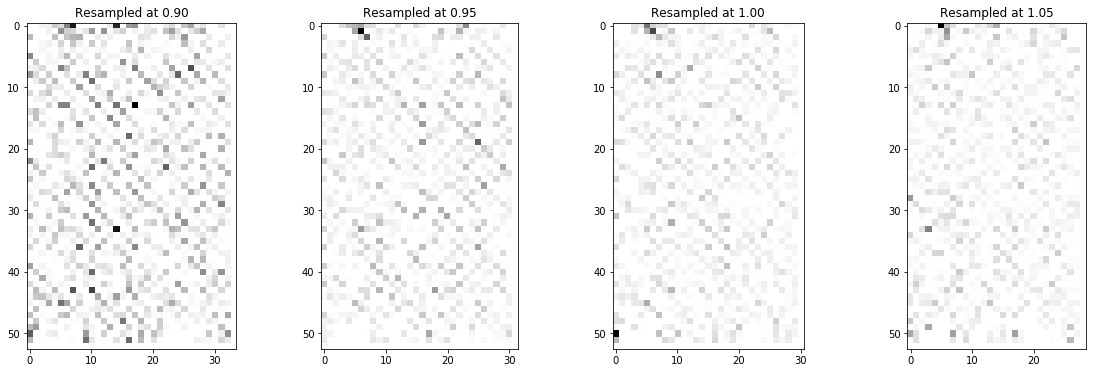

In [40]:
import matplotlib.gridspec as gridspec

plt.figure(figsize = (20,6))
gs = gridspec.GridSpec(1, len(scales))
gs.update(wspace=.15, hspace=.5)

for i, r in enumerate(resampled_references):
    plt.subplot(gs[i])
    sim = filter_similarity_matrix(fft_sequence_similarity(cover_ffts, r)[0])
    plt.imshow(sim, cmap='Greys', interpolation='none', aspect = 1)
    plt.title('Resampled at %.2f' % scales[i])
    
plt.show()

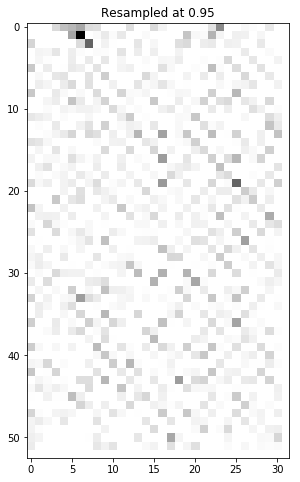

In [41]:
sim = filter_similarity_matrix(fft_sequence_similarity(cover_ffts, resampled_references[1])[0])
plt.figure(figsize=(8, 8))
plt.imshow(sim, cmap='Greys', interpolation='none', aspect = 1)
plt.title('Resampled at %.2f' % scales[1])
plt.show()

In [42]:
def find_diagonals(S):
    diagonals = []
    diagonal_locations = []
    for i in range(-max(S.shape) + 1, max(S.shape)):
        diag = S.diagonal(i)
        diag_indices = get_diagonal_indices(S.shape, i)
        current_length = 0
        current_weight = 0
        for j in range(0, len(diag)):
            if diag[j] > 0 and j != len(diag):
                current_length += 1
                current_weight += diag[j]
            else:
                if current_length > 1:
                    if j == len(diag) - 1 and diag[j] > 0:
                        current_weight += diag[j]
                        current_length += 1
                        diagonal_locations.append((diag_indices[j - current_length], diag_indices[j]))
                    else:
                        diagonal_locations.append((diag_indices[j - current_length], diag_indices[j-1]))
                    diagonals.append(current_length*current_weight)   
                current_length = 0
                current_weight = 0
    zipped = zip(diagonals, diagonal_locations)
    zipped = sorted(zipped, reverse=True, key = lambda x: x[0])
    return [x[0] for x in zipped], [x[1] for x in zipped]

In [43]:
def measure_distance(query_fingerprint, references):
    min_distance = np.inf
    for reference_fingerprint in references:
        if len(reference_fingerprint) != 0 and len(query_fingerprint) != 0:
	    sim_matrix, energy = fft_sequence_similarity(query_fingerprint, reference_fingerprint)
	    filtered = filter_similarity_matrix(sim_matrix)
	    diagonals, offsets = find_diagonals(filtered)
	    significant_diagonals = np.sum(diagonals[:3])
	    distance = energy/(significant_diagonals + .01)
        if distance < min_distance:
            min_distance = distance
    return min_distance, offsets

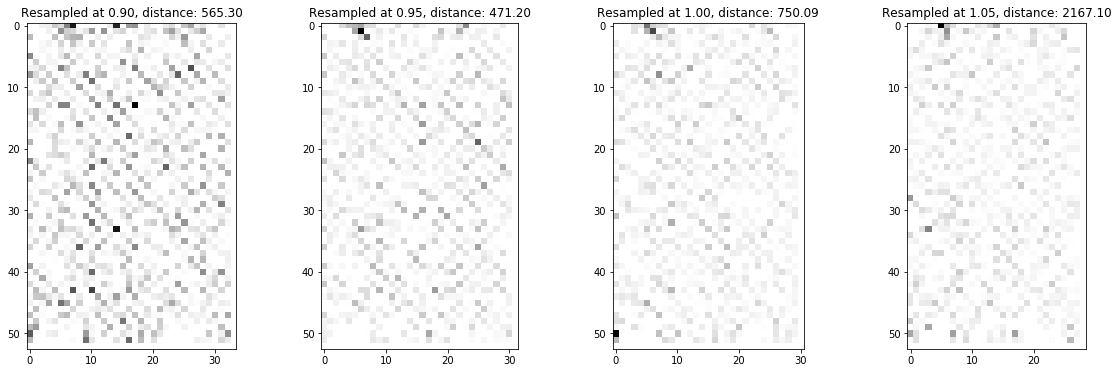

In [44]:
plt.figure(figsize = (20,6))
gs = gridspec.GridSpec(1, len(scales))
gs.update(wspace=.15, hspace=.5)

for i, r in enumerate(resampled_references):
    plt.subplot(gs[i])
    distance = measure_distance(cover_ffts, [r])[0]
    sim = filter_similarity_matrix(fft_sequence_similarity(cover_ffts, r)[0])
    plt.imshow(sim, cmap='Greys', interpolation='none', aspect = 1)
    plt.title('Resampled at %.2f, distance: %.2f' % (scales[i], distance))
    
plt.show()

In [45]:
def show_similarity_matrix(S, t, stretch, y, x, offsets, size = (10, 10)):
    plt.figure(figsize=size)
    plt.imshow(S, cmap='Greys', interpolation='none')
    plt.title(t)
    plt.yticks(range(S.shape[0])[::2], [str(datetime.timedelta(seconds=np.round(20*.2*i, 0))) 
                                   for i in range(S.shape[0])][::2])
    plt.xticks(range(S.shape[1])[::2], [str(datetime.timedelta(seconds=np.round(20*.2*i*stretch, 0))) 
                                   for i in range(S.shape[1])][::2], rotation='vertical')
    plt.grid()
    plt.ylabel(y)
    plt.xlabel(x)
    for i, d in enumerate(offsets):
        #plt.text(d[0][1], d[0][0], d[0], color='g', horizontalalignment='center')
        #plt.text(d[1][1], d[1][0], d[1], color='r', horizontalalignment='center')
        if i < 3:
            plt.plot([d[0][1], d[1][1]], [d[0][0], d[1][0]], color='b')
        else:
            plt.plot([d[0][1], d[1][1]], [d[0][0], d[1][0]], color='b', linestyle='dotted')
    plt.show()
    
def compare_cover_to_reference(song_file, cover_file, scale, title):
    resampled_references = []
    song, sr = librosa.load(song_file)

    ap['sample_rate'] = scale*sr
    song_fp = fingerprint(song, ap)[1]
    song_ffts = fingerprint_fft(song_fp, ap, fingerprint_parameters)
    resampled_reference = song_ffts

    cover, sr = librosa.load(cover_file)
    
    ap['sample_rate'] = sr
    cover_fp = fingerprint(cover, ap)[1]
    cover_ffts = fingerprint_fft(cover_fp, ap, fingerprint_parameters)
    
    distance, offsets = measure_distance(cover_ffts, [resampled_reference])
    sim = filter_similarity_matrix(fft_sequence_similarity(cover_ffts, resampled_reference)[0])
    t = title + '\nDistance: %.2f - Time stretch: %.2f' % (distance, scale)
    show_similarity_matrix(sim, t, scales[i],
                   'Cover', 
                   'Reference',
                    offsets)
    
    for o in offsets[0:3]:
        match = [str(datetime.timedelta(seconds=np.round(4*o[0][0], 0))), 
                 str(datetime.timedelta(seconds=np.round(4*o[1][0], 0))),
                 str(datetime.timedelta(seconds=np.round(4*o[0][1], 0))),
                 str(datetime.timedelta(seconds=np.round(4*o[1][1], 0)))]
        print 'Matched %s -> %s in the cover to %s -> %s in the reference' % tuple(match)
        audio(cover[sr*o[0][0]*4:sr*o[1][0]*4], sr)
        audio(song[int(scale*sr*o[0][1]*4):int(scale*sr*o[1][1]*4)], sr)

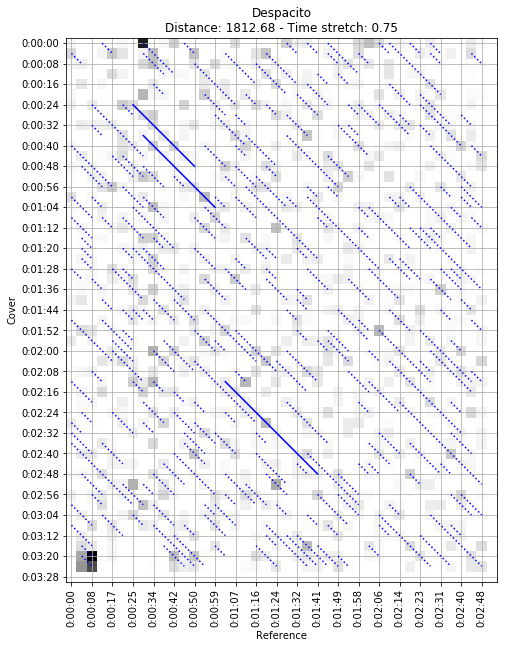

Matched 0:02:12 -> 0:02:48 in the cover to 0:01:00 -> 0:01:36 in the reference


Matched 0:00:36 -> 0:01:04 in the cover to 0:00:28 -> 0:00:56 in the reference


Matched 0:00:24 -> 0:00:48 in the cover to 0:00:24 -> 0:00:48 in the reference


In [46]:
compare_cover_to_reference("../data/test_data/Luis Fonsi - Despacito ft. Daddy Yankee.mp3", 
                           "../data/test_data/Despacito cover - Luciana Zogbi.mp3", 
                           .75, 
                           "Despacito")